# Description of the Data Set
this dataset conist of resumes of ML engineers and formatted in pdfs.

# Aim of this project
The aim is to estimate the score of the resume and then shrortlist based on them.

In [ ]:
!pip install PyMuPDF

In [ ]:
!pip install text_hammer

### Required Packages

In [3]:
import  text_hammer as th
import os,re
import fitz  #extract text page by page
import pandas as pd
import numpy as np
from numpy import array, asarray, zeros
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Input, Flatten, LSTM, Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Initialization

In [5]:
train_path = '/content/drive/MyDrive/76fbb052f9b711eb/dataset/trainResumes/'
test_path = '/content/drive/MyDrive/76fbb052f9b711eb/dataset/testResumes/'

In [6]:
resumes_train =[]
for i in range(len(os.listdir(train_path))):
  with fitz.open(train_path + os.listdir(train_path)[i]) as doc:
    train_text = ""
    for page in doc:
        train_text += page.getText() 
        resumes_train.append(train_text)

In [7]:
resumes_test =[]

for i in range(len(os.listdir(test_path))):
  with fitz.open(test_path + os.listdir(test_path)[i]) as doc:
    test_text = ""
    for page in doc:
        test_text += page.getText() 
        resumes_test.append(test_text)

In [8]:
resumes_train1=[]
for i in resumes_train:
  resumes_train1.append(i)

In [9]:
resumes_test1=[]
for i in resumes_test:
  resumes_test1.append(i)

In [10]:
train_df = pd.read_csv('/content/drive/MyDrive/76fbb052f9b711eb/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/76fbb052f9b711eb/dataset/test.csv')

## Data-Fetching

In [11]:
train_df['details'] = resumes_train1
test_df['details'] = resumes_test1

In [12]:
train_df.head()

,CandidateID,Match Percentage,details
0,candidate_011,13.60,JENNIFER ARMSTRONG\nPROFILE\nFresher Computer ...
1,candidate_113,36.63,LIAM ANDREWS\nFRESHER\nWORK EXPERIENCE\nIntern...
2,candidate_123,54.93,CutThroat Media \nNLP analyst for user comment...
3,candidate_012,41.46,"JACOB SMITH\nF R E S H E R\nSKILLS\nPython, SQ..."
4,candidate_002,48.91,"AMZ Loans and Mortgages\nERC Analytics, Jun 20..."


## Data Cleaning

In [13]:
def Text_cleaning(df, column):
    column = column
    print(column)
    """column must be a string value"""
    df[column] = df[column].progress_apply(lambda x: re.sub('"',"'", x))
    df[column] = df[column].progress_apply(lambda x: re.sub('\n+',' ', x))
    df[column] = df[column].progress_apply(lambda x:th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_urls(x))
    df[column] = df[column].progress_apply(lambda x:th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: re.sub('[^a-zA-Z]+',' ', x))
    df[column] = df[column].progress_apply(lambda x:' '.join([x for x in x.split() if len(x)>=2]) )
    return df[column]



In [14]:
cleaned_train= Text_cleaning(train_df, 'details')

details


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [15]:
cleaned_test= Text_cleaning(test_df, 'details')


details


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
train_df['details'] = cleaned_train
test_df['details'] = cleaned_test


In [17]:
train_df.head()


,CandidateID,Match Percentage,details
0,candidate_011,13.60,JENNIFER ARMSTRONG PROFILE Fresher Computer vi...
1,candidate_113,36.63,LIAM ANDREWS FRESHER WORK EXPERIENCE Intern Tr...
2,candidate_123,54.93,CutThroat Media NLP analyst for user comments ...
3,candidate_012,41.46,JACOB SMITH SKILLS Python SQL MySQL Tableau Po...
4,candidate_002,48.91,AMZ Loans and Mortgages ERC Analytics Jun to t...


In [18]:
test_df.head()

,CandidateID,details
0,candidate_014,ARMIN FITZGERALD DA PROFESSIONAL PROFILE Exper...
1,candidate_098,EVELYNN ADAMS GRADUATE FRESHER PROFESSIONAL PR...
2,candidate_075,OLIVIA SANTOS CONSULTANT ANALYST WORK EXPERIEN...
3,candidate_016,AMELIA MARTIN DATA SCIENCE MAJOR WORK EXPERIEN...
4,candidate_131,GRACE BAILRY SKILLS Software EngineerDeveloper...


## Data Splitting

In [19]:
X_train =  train_df.iloc[:, 2]
X_test =  test_df.iloc[:, 1]
y_train =  train_df.iloc[:, 1]

In [20]:
a=[]
for i in X_train[:]:
  a.append(len(i))
max(a)

1470

In [21]:
my_stopwords = stopwords.words('english')


### Adding Glove (6B, 100d)

In [22]:
embd_dic = dict()
glove = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding ='utf8')
for line in glove:
  records = line.split()
  word = records[0]
  vec_dim = asarray(records[1:], dtype='float32')
  embd_dic[word] = vec_dim
glove.close()

### Implementing TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(stop_words=my_stopwords)
bag_of_words = vectorizer.fit_transform(X_train)
vectorizer_test = TfidfVectorizer(stop_words=my_stopwords)
bag_of_words_test = vectorizer_test.fit_transform(X_test)

In [24]:
print(f'sparity of bag of words: {len(bag_of_words.data)/ (bag_of_words.shape[0]*bag_of_words.shape[1]*100)}')

sparity of bag of words: 0.00034397870924817033


In [25]:
list(vectorizer.vocabulary_.keys())[:10]

['jennifer',
 'armstrong',
 'profile',
 'fresher',
 'computer',
 'vision',
 'machine',
 'learning',
 'engineer',
 'looking']

In [26]:
bag_of_words.shape, len(vectorizer.vocabulary_)

((90, 2171), 2171)

In [27]:
embds = []
zero_embd = 100*[0]
for key, val in sorted(vectorizer.vocabulary_.items(), key = lambda kv: (kv[1], kv[0])):
  if key in embd_dic:
    embds.append(embd_dic[key])
  else:
    embds.append(zero_embd)
  if val%100==0:
    print(val, key)

0 abberns
100 apache
200 believe
300 carlton
400 comparisons
500 databricks
600 distance
700 exams
800 franchise
900 hardworking
1000 informatics
1100 jr
1200 look
1300 microsoft
1400 nyugen
1500 pillow
1600 pune
1700 results
1800 service
1900 steam
2000 took
2100 vishwavidyalaya


In [28]:
embds_test = []
zero_embd_test = 100*[0]
for key, val in sorted(vectorizer_test.vocabulary_.items(), key = lambda kv: (kv[1], kv[0])):
  if key in embd_dic:
    embds_test.append(embd_dic[key])
  else:
    embds_test.append(zero_embd)
  if val%100==0:
    print(val, key)

0 ability
100 assist
200 business
300 computation
400 departement
500 enginee
600 fresher
700 hindi
800 java
900 lodged
1000 models
1100 outcomes
1200 project
1300 sanghvi
1400 specializing
1500 tools
1600 williams


In [29]:
bag_of_words_test.shape, len(vectorizer_test.vocabulary_)


((60, 1627), 1627)

In [30]:
my_embds = sparse.csr_matrix(embds)
my_embds_test = sparse.csr_matrix(embds_test)

In [31]:
doc_embds = bag_of_words.dot(my_embds)
doc_embds_test = bag_of_words_test.dot(my_embds_test)

In [32]:
doc_embds.shape

(90, 100)

In [33]:
doc_embds[:10]

<10x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [34]:
doc_embds_test.shape


(60, 100)

## Model Selection

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(doc_embds, y_train, test_size=0.20, random_state=42)


## Implementing ML Models 

In [37]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 800, 1400, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import plot_roc_curve

In [39]:
dt = DecisionTreeRegressor(max_depth=25)

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

sv = SVR(kernel='rbf',gamma='auto',degree=2)


In [40]:
dt.fit(X_train_de,y_train_de)
rf_random.fit(X_train_de,y_train_de)
sv.fit(X_train_de,y_train_de)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.5min finished


SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
from xgboost import XGBRegressor
xg = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [42]:
xg.fit(X_train_de,y_train_de)

y_pred1 = xg.predict(X_test_de)


[13:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [43]:
y_pred2 = dt.predict(X_test_de)
y_pred3 = rf_random.predict(X_test_de)
y_pred4 = sv.predict(X_test_de)

In [44]:
print(100*max(0, 1 - mean_squared_log_error(y_test_de, y_pred1)))
print(100*max(0, 1 - mean_squared_log_error(y_test_de, y_pred2)))
print(100*max(0, 1 - mean_squared_log_error(y_test_de, y_pred3)))
print(100*max(0, 1 - mean_squared_log_error(y_test_de, y_pred4)))

61.39323910006629
51.388790685990834
59.605462722241676
59.54073586397912


## Tensorflow Model

In [45]:
# len(X_test_sub)

In [46]:
maxlen=100
l1_thres = 1e-4
l2_thres = 1e-5
deep_inputs = Input(shape=(maxlen,))
# lstm_layer = LSTM(maxlen,  dropout=0.5)(deep_inputs)
dense_layer_1 = Dense(90,activation='linear')(deep_inputs)
dense_layer_2 = Dense(30,activation='linear')(dense_layer_1)
dense_layer_3 = Dense(1,activation='linear')(dense_layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_3)
opt = Adam(learning_rate=0.1)

model.compile(loss='mean_absolute_error', optimizer=opt)

In [47]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 90)                9090      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
X_res = X_train_de.todense()
y_res = y_train_de

In [49]:
history = model.fit(X_res, y_res, batch_size=256, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 38.0784 - val_loss: 200.3138
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 200.6101 - val_loss: 776.8343
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 781.3568 - val_loss: 361.5923
Epoch 4/50
1/1 [==============================] - 0s 34ms/step - loss: 365.0322 - val_loss: 111.2004
Epoch 5/50
1/1 [==============================] - 0s 25ms/step - loss: 109.3831 - val_loss: 133.3570
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 131.6342 - val_loss: 14.2047
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 11.7142 - val_loss: 109.0516
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 111.7625 - val_loss: 133.9749
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 136.9003 - val_loss: 102.2317
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 105.1273 - val_loss: 53.

dict_keys(['loss', 'val_loss'])


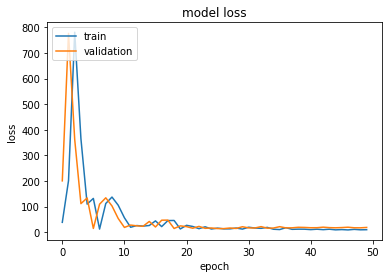

In [50]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [51]:
output = model.predict(X_test_de)

In [52]:
print(max(0, 1 - mean_squared_log_error(y_test_de, output)))


0.43455095712664027


In [53]:
predicted = model.predict(doc_embds_test.todense())
# match_percentage=[]
# for i in predicted.tolist():
#   for j in i:
#     match_percentage.append(j)

match_percentage = [item for sublist in predicted for item in sublist]


test_df['Match Percentage'] = rf_random.predict(doc_embds_test)

In [54]:
test_df1 = test_df.drop(['details'], axis=1)
test_df1.head()

,CandidateID,Match Percentage
0,candidate_014,39.149242
1,candidate_098,42.096417
2,candidate_075,36.677114
3,candidate_016,42.984828
4,candidate_131,43.245310


In [55]:
test_df1.to_csv('predicted_score1.csv', encoding='utf-8')

In [56]:
test_df1.to_csv('predicted_score.csv', encoding='utf-8')


### LSTM Based Model

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [57]:
X_train_sub,X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2)

In [58]:
max(len(t) for t in X_train_sub)

1470

In [59]:
type(X_train_sub)

pandas.core.series.Series

In [60]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sub = tokenizer.texts_to_sequences(X_train_sub)
X_test_sub = tokenizer.texts_to_sequences(X_test_sub)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 1470

X_train_sub = pad_sequences(X_train_sub, padding='post', maxlen=maxlen)
X_test_sub = pad_sequences(X_test_sub, padding='post', maxlen=maxlen)

In [61]:
tokenizer.word_index

{'data': 1,
 'and': 2,
 'learning': 3,
 'to': 4,
 'machine': 5,
 'of': 6,
 'in': 7,
 'the': 8,
 'analysis': 9,
 'for': 10,
 'python': 11,
 'on': 12,
 'from': 13,
 'with': 14,
 'skills': 15,
 'projects': 16,
 'analytics': 17,
 'business': 18,
 'using': 19,
 'experience': 20,
 'science': 21,
 'work': 22,
 'deep': 23,
 'profile': 24,
 'engineer': 25,
 'analyst': 26,
 'university': 27,
 'processing': 28,
 'software': 29,
 'as': 30,
 'education': 31,
 'based': 32,
 'intern': 33,
 'developer': 34,
 'natural': 35,
 'language': 36,
 'college': 37,
 'models': 38,
 'activities': 39,
 'engineering': 40,
 'nlp': 41,
 'till': 42,
 'date': 43,
 'development': 44,
 'intelligence': 45,
 'management': 46,
 'btech': 47,
 'am': 48,
 'sql': 49,
 'worked': 50,
 'other': 51,
 'fresher': 52,
 'that': 53,
 'an': 54,
 'text': 55,
 'solutions': 56,
 'system': 57,
 'my': 58,
 'history': 59,
 'have': 60,
 'statistical': 61,
 'mining': 62,
 'visualization': 63,
 'regression': 64,
 'junior': 65,
 'executive': 66,
 

In [62]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embd_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Using Glove Vectors

In [63]:
import tensorflow as tf


In [64]:
model_lstm_trans_reg = tf.keras.Sequential([
    Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=256,
        mask_zero=True),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, input_shape=(maxlen,))),
    tf.keras.layers.Dense(16, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])


opt = Adam(learning_rate=0.1)
# msle = tf.keras.losses.mean_squared_logarithmic_error
model_lstm_trans_reg.compile(loss='mse', optimizer=opt)

In [65]:
print(model_lstm_trans_reg.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1470, 256)         576000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 974,369
Trainable params: 974,369
Non-trainable params: 0
_________________________________________________________________
None


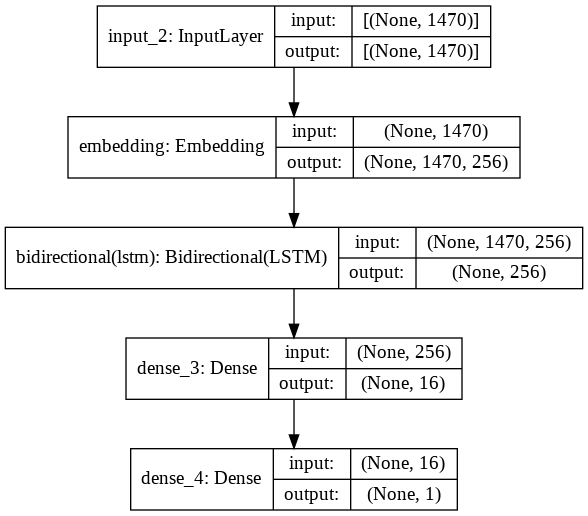

In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model_lstm_trans_reg, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [67]:
history = model_lstm_trans_reg.fit(X_train_sub, y_train_sub, batch_size=32, epochs=500, verbose=2, validation_split=0.2,
                                   validation_data=(X_test_sub, y_test_sub) )

Epoch 1/500
2/2 - 14s - loss: 1107.0461 - val_loss: 12698.7559
Epoch 2/500
2/2 - 0s - loss: 8507.0820 - val_loss: 881.4310
Epoch 3/500
2/2 - 0s - loss: 1272.8937 - val_loss: 2494.8696
Epoch 4/500
2/2 - 0s - loss: 1979.3442 - val_loss: 1829.8824
Epoch 5/500
2/2 - 0s - loss: 1266.0862 - val_loss: 571.2460
Epoch 6/500
2/2 - 0s - loss: 428.3113 - val_loss: 121.3686
Epoch 7/500
2/2 - 0s - loss: 405.4988 - val_loss: 366.0820
Epoch 8/500
2/2 - 0s - loss: 374.3446 - val_loss: 214.9251
Epoch 9/500
2/2 - 0s - loss: 193.0694 - val_loss: 152.2822
Epoch 10/500
2/2 - 0s - loss: 93.7699 - val_loss: 156.8990
Epoch 11/500
2/2 - 0s - loss: 76.6540 - val_loss: 203.5420
Epoch 12/500
2/2 - 0s - loss: 38.1687 - val_loss: 193.4178
Epoch 13/500
2/2 - 0s - loss: 21.2191 - val_loss: 198.4315
Epoch 14/500
2/2 - 0s - loss: 16.2760 - val_loss: 199.1928
Epoch 15/500
2/2 - 0s - loss: 18.8333 - val_loss: 182.4879
Epoch 16/500
2/2 - 0s - loss: 14.8676 - val_loss: 199.1473
Epoch 17/500
2/2 - 0s - loss: 13.3660 - val_lo

In [68]:
lstm_output = model_lstm_trans_reg.predict(X_test_sub)

In [70]:
print(max(0, 1 - mean_squared_log_error(y_test_sub, lstm_output)))


0.4664766708001882


In [71]:
predicted = model_lstm_trans_reg.predict(doc_embds_test.todense())
match_percentage = [item for sublist in predicted.tolist() for item in sublist]

test_df['Match Percentage'] = match_percentage

In [72]:
test_df1 = test_df.drop(['details'], axis=1)
test_df1.head(60)

,CandidateID,Match Percentage
0,candidate_014,55.330864
1,candidate_098,30.809883
2,candidate_075,5.391693
3,candidate_016,37.870319
4,candidate_131,19.551712
5,candidate_056,26.536737
6,candidate_141,16.500689
7,candidate_044,29.020947
8,candidate_029,34.990456
9,candidate_120,25.238867


In [ ]:
test_df1.to_csv('predicted_score_lstm.csv', encoding='utf-8')

# AutoEncoders

In [ ]:
!pip install pyod

### Model

Auto Encoder (AE) is a type of neural networks for learning useful data representations unsupervisedly. Similar to PCA, AE could be used to detect outlying objects in the data by calculating the reconstruction errors. 

### Tuning Parameters
>**hidden_neurons** (list, optional (default=[64, 32, 32, 64])) – The number of neurons per hidden layers.

>**hidden_activation** (str, optional (default='relu')) – Activation function to use for hidden layers. All hidden layers are forced to use the same type of activation. See https://keras.io/activations/

>**output_activation** (str, optional (default='sigmoid')) – Activation function to use for output layer. See https://keras.io/activations/

>**loss** (str or obj, optional (default=keras.losses.mean_squared_error)) – String (name of objective function) or objective function. See https://keras.io/losses/

>**optimizer** (str, optional (default='adam')) – String (name of optimizer) or optimizer instance. See https://keras.io/optimizers/

>**epochs** (int, optional (default=100)) – Number of epochs to train the model.

>**batch_size** (int, optional (default=32)) – Number of samples per gradient update.

>**validation_size** (float in (0., 1), optional (default=0.1)) – The percentage of data to be used for validation.


**For More Details** [Auto Encoder API](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.auto_encoder)

In [88]:

from pyod.models.auto_encoder import AutoEncoder

inner_units = round(doc_embds.shape[1]/2)
model_ae = AutoEncoder(epochs=500, 
                    contamination=0.05, 
                    hidden_neurons = [doc_embds.shape[1],inner_units,inner_units,doc_embds.shape[1]]) 

In [93]:
# X_train_de, X_test_de, y_train_de, y_test_de
model_ae.fit(X_train_de.todense())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 50)               

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=500,
      hidden_activation='relu', hidden_neurons=[100, 50, 50, 100],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f7011f4a0e0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [94]:
result=model.predict(X_test_de)

In [95]:
print(max(0, 1 - mean_squared_log_error(y_test_sub, result)))


0.8838388319182974
